<a href="https://colab.research.google.com/github/LxYuan0420/aws-machine-learning-university-accelerated-nlp/blob/master/colab_notebook/MLA_NLP_Lecture2_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Colab Notebooks/git/aws-machine-learning-university-accelerated-nlp/colab_notebooks

/gdrive/MyDrive/Colab Notebooks/git/aws-machine-learning-university-accelerated-nlp/colab_notebooks


**Machine Learning Accelerator - Natural Language Processing - Lecture 2**

Linear Regression Models and Regularization
In this notebook, we go over Linear Regression methods (with and without regularization: LinearRegression, Ridge, Lasso, ElasticNet) to predict the log_votes field of our review dataset.

1. Reading the dataset
1. Exploratory data analysis
1. Stop word removal and stemming
1. Train - Validation Split
1. Data processing with Pipeline and ColumnTransform
1. Train the regressor
1. Fitting Linear Regression models and checking the validation performance Find more details on the classical Linear Regression models with and without regularization here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
1. Ideas for improvement


Overall dataset schema:

1. reviewText: Text of the review
1. summary: Summary of the review
1. verified: Whether the purchase was verified (True or False)
1. time: UNIX timestamp for the review
1. rating: Rating of the review
1. log_votes: Logarithm-adjusted votes log(1+votes)
1. isPositive: Whether the review is positive or negative (1 or 0)

**1. Reading the dataset**

In [3]:
import pandas as pd

df = pd.read_csv('../data/examples/AMAZON-REVIEW-DATA-CLASSIFICATION.csv')
df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


**2. Exploratory data analysis**

In [4]:
df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

In [5]:
df.isna().sum()

reviewText    11
summary       14
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64

**3. Text Processing: Stop words removal and stemming**


In [6]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:

import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

**4. Train - validation Split**

9/1 split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "log_votes"]],
                                                  df["isPositive"],
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state=42)

In [11]:
print("Processing the reviewText field")

X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())


Processing the reviewText field


In [12]:
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

**5. Data processing with Pipeline and ColumnTransform**

In the previous examples, we have seen how to use pipeline to prepare a data field for our machine learning model. This time, we will focus on multiple fields: numeric and text fields. We are using linear regression model from Sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model.

For the numerical features pipeline, the numerical_processor below, we use a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
For the numerical features pipeline, the text_processor below, we use CountVectorizer() for the text fields.
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [13]:
numerical_features = ["time", "log_votes"]
text_features = ["summary", "reviewText"]

model_features = numerical_features + text_features
model_target = "isPositive"

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Column Transformer
numerical_processor = Pipeline([("num_scalar", MinMaxScaler())])

# preprocess text features
text_preprocessor_0 = Pipeline([("text_vect_0", CountVectorizer(binary=True, max_features=50))])
text_preprocessor_1 = Pipeline([("text_vect_1", CountVectorizer(binary=True, max_features=150))])

data_preprocessor = ColumnTransformer([
    ("numerical_pre", numerical_processor, numerical_features),
    ("text_pre_0", text_preprocessor_0, text_features[0]),
    ("text_pre_1", text_preprocessor_1, text_features[1])
])


# Pipeline 
pipeline = Pipeline([
    ("data_preprocessing", data_preprocessor),
    ("logisticRegression", LogisticRegression(penalty="l2", C=0.1))
])

**6. Train Regressor**

In [16]:
pipeline.fit(X_train, y_train.values)

Pipeline(memory=None,
         steps=[('data_preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical_pre',
                                                  Pipeline(memory=None,
                                                           steps=[('num_scalar',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                               

**7. Fitting Linear Regression models and checking the validation performance**

7.1 LinearRegression
Let's first fit LinearRegression from Sklearn library, and check the performance on the validation dataset. Using the coef_ atribute, we can also print the learned weights of the model.

Find more details on LinearRegression here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

val_pred = pipeline.predict(X_val)
print(classification_report(y_val.values, val_pred))
print(f"Accuracy on validation set: {accuracy_score(y_val.values, val_pred)}")


              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      2557
         1.0       0.87      0.90      0.88      4443

    accuracy                           0.85      7000
   macro avg       0.84      0.83      0.84      7000
weighted avg       0.85      0.85      0.85      7000

Accuracy on validation set: 0.8502857142857143


**7.2 Ridge (Linear Regression with L2 regularization)**

Let's now fit Ridge from Sklearn library, and check the performance on the validation dataset.

Find more details on Ridge here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

To improve the performance of a LinearRegression model, Ridge is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$
where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

ridge_pipeline = Pipeline([
    ("data_preprocessing", data_preprocessor),
    ("ridge", Ridge(alpha=100))
])

ridge_pipeline.fit(X_train[model_features], y_train.values)
ridgeRegressor_val_predictions = ridge_pipeline.predict(X_val[model_features])

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

Ridge on Validation: Mean_squared_error: 0.649729,  R_square_score: 0.360753


**8. Ideas for improvement: Probability threshold calibration (optional)**
(Go to top)

Besides tuning LogisticRegression hyperparameter values, one other path to improve a classifier's performance is to dig deeper into how the classifier actually assigns class membership.

Binary predictions versus probability predictions. We often use classifier.predict() to examine classifier binary predictions, while in fact the outputs of most classifiers are real-valued, not binary. For most classifiers in sklearn, the method classifier.predict_proba() returns class probabilities as a two-dimensional numpy array of shape (n_samples, n_classes) where the classes are lexicographically ordered.

For our example, let's look at the first 5 predictions we made, in binary format and in real-valued probability format:

In [19]:
pipeline.predict(X_val[:5])

array([0., 1., 1., 0., 1.])

In [20]:
pipeline.predict_proba(X_val[:5])

array([[0.98079652, 0.01920348],
       [0.18440064, 0.81559936],
       [0.14161248, 0.85838752],
       [0.98634217, 0.01365783],
       [0.00965051, 0.99034949]])

How are the predicted probabilities used to decide class membership? On each row of predict_proba output, the probabilities values sum to 1. There are two columns, one for each response class: column 0 - predicted probability that each observation is a member of class 0; column 1 - predicted probability that each observation is a member of class 1. From the predicted probabilities, choose the class with the highest probability.

The key here is that a threshold of 0.5 is used by default (for binary problems) to convert predicted probabilities into class predictions: class 0, if predicted probability is less than 0.5; class 1, if predicted probability is greater than 0.5.

Can we improve classifier performance by changing the classification threshold? Let's adjust the classification threshold to influence the performance of the classifier.

**8.1 Threshold calibration to improve model accuracy**

We calculate the accuracy using different values for the classification threshold, and pick the threshold that resulted in the highest accuracy.

Highest Acc on Val: 0.8504285714285714
Best threshold to get highest Acc on Val: 0.55


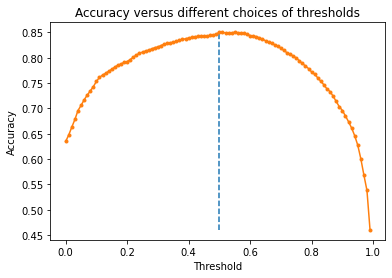

In [22]:
import numpy as np
import matplotlib.pyplot as plt

highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0, 1, 0.01)
scores = []
for t in thresholds:
    y_val_other = (pipeline.predict_proba(X_val)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if (score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print(f"Highest Acc on Val: {highest_accuracy}")
print(f"Best threshold to get highest Acc on Val: {threshold_highest_accuracy}")

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [29]:
# F1 score

from sklearn.metrics import precision_recall_curve

# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = pipeline.predict_proba(X_val)
precisions, recalls, thresholds = precision_recall_curve(y_val, val_predictions_probs[:, 1])

Highest F1 score on Validation: 0.8841402337228715 , Threshold for the highest F1 score: 0.506274101066882


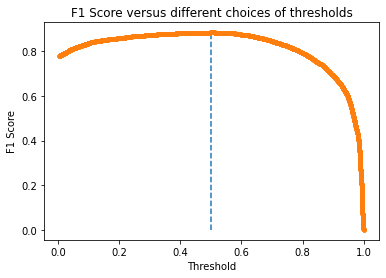

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the F1 score using different values for the classification threshold, 
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0

f1_scores = []
for id, threhold in enumerate(thresholds):
    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threhold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)

# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

In [32]:
thresholds

array([0.00363552, 0.00369655, 0.00383712, ..., 0.99991239, 0.99992963,
       0.99999169])

In [34]:
len(thresholds)

6965